# Main Modelling Notebook

In [1]:
import itertools as it
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import scipy as sp
import sklearn.preprocessing as Preprocessing
import datetime

from itertools import combinations
from sklearn.cross_validation import KFold as kfold
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from scipy.io import mmread

%matplotlib inline
plt.style.use('ggplot') 
from IPython.display import display, HTML

#### Load Data

In [52]:
# load data
%run -i data_loading.py

173805
79052
address_state object
annual_income float64
cpi float64
delinq_2_yrs int64
desc_len float64
dti float64
employ_length object
employ_title object
gdp float64
home_owner object
initial_list_status object
inquiry_6_mos int64
installment float64
interest_rate float64
ipr float64
loan_amount int64
loan_purpose object
loan_term int64
months_since_last_record float64
open_accounts int64
revol_util float64
rir float64
total_accounts int64
unemploy float64
months_since_earliest_credit float64
Indexes computed
19719
59333
PCA: first and last columns where % variance explained >= 99: [62 99]
PCA: first and last columns where % variance explained >= 85: Exception!


#### Set up Modelling Framework

In [57]:
# set up modelling framework
% run -i modelling_framework.py

#### Models without PCA

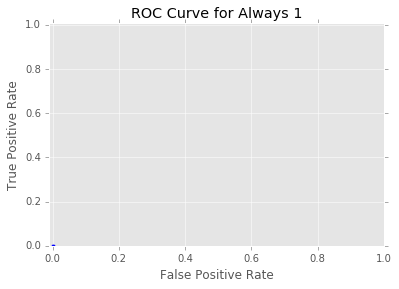

all   score: 0.845  baseline: 0.845   1-prec: 0.845   f1: 0.000  | test score 0.152  1-prec 0.848 f1 0.263  GP 851MM
2011  score: 0.887  baseline: 0.887   wscore: 0.887   f1: 0.000  | test score 0.896  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.867   f1: 0.000  | test score 0.863  1-prec 0.863
2013  score: 0.818  baseline: 0.818   wscore: 0.818   f1: 0.000  | test score 0.825  1-prec 0.825


In [58]:
eval_model_by_year(lambda: DummyClassifier(strategy='constant', constant=0), model_name='Always 1')

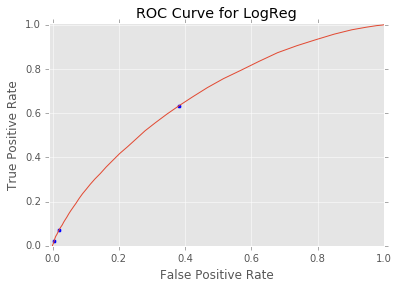

all   score: 0.844  baseline: 0.845   1-prec: 0.848   f1: 0.043  | test score 0.152  1-prec 0.851 f1 0.259  GP 840MM
2011  score: 0.886  baseline: 0.887   wscore: 0.888   f1: 0.035  | test score 0.895  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.868   f1: 0.014  | test score 0.862  1-prec 0.864
2013  score: 0.816  baseline: 0.818   wscore: 0.824   f1: 0.098  | test score 0.822  1-prec 0.830


In [59]:
eval_model_by_year(lambda: Log_Reg(), model_name='LogReg')

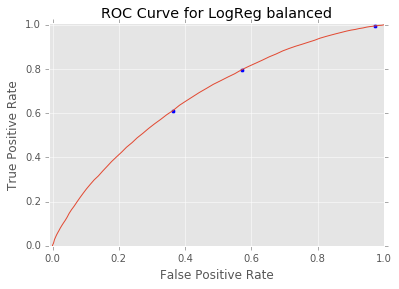

all   score: 0.643  baseline: 0.845   1-prec: 0.905   f1: 0.353  | test score 0.367  1-prec 0.902 f1 0.157  GP 273MM
2011  score: 0.635  baseline: 0.887   wscore: 0.913   f1: 0.243  | test score 0.638  1-prec 0.928
2012  score: 0.637  baseline: 0.867   wscore: 0.916   f1: 0.310  | test score 0.611  1-prec 0.901
2013  score: 0.645  baseline: 0.818   wscore: 0.887   f1: 0.391  | test score 0.637  1-prec 0.887


In [60]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), model_name='LogReg balanced')

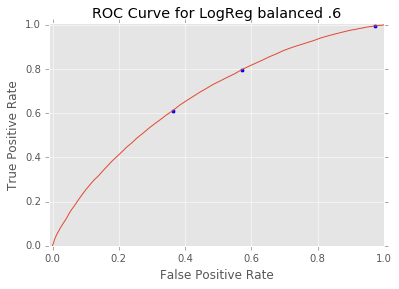

all   score: 0.643  baseline: 0.845   1-prec: 0.923   f1: 0.353  | test score 0.515  1-prec 0.922 f1 0.113  GP -20MM
2011  score: 0.635  baseline: 0.887   wscore: 0.915   f1: 0.243  | test score 0.638  1-prec 0.940
2012  score: 0.637  baseline: 0.867   wscore: 0.934   f1: 0.310  | test score 0.611  1-prec 0.919
2013  score: 0.645  baseline: 0.818   wscore: 0.909   f1: 0.391  | test score 0.637  1-prec 0.908


In [61]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), prob_threshold=.6, model_name='LogReg balanced .6')

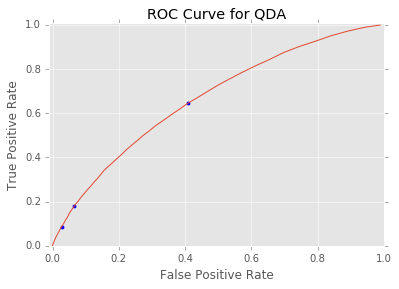

all   score: 0.836  baseline: 0.845   1-prec: 0.853   f1: 0.135  | test score 0.162  1-prec 0.856 f1 0.249  GP 791MM
2011  score: 0.869  baseline: 0.887   wscore: 0.894   f1: 0.153  | test score 0.866  1-prec 0.901
2012  score: 0.860  baseline: 0.867   wscore: 0.869   f1: 0.044  | test score 0.858  1-prec 0.865
2013  score: 0.804  baseline: 0.818   wscore: 0.831   f1: 0.189  | test score 0.809  1-prec 0.838


In [62]:
eval_model_by_year(lambda: QDA(reg_param = 1), model_name='QDA')

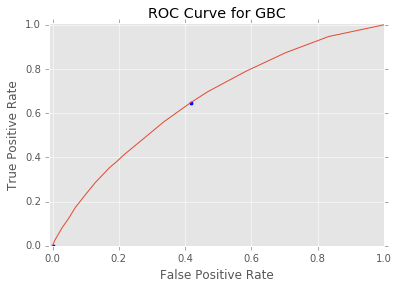

all   score: 0.845  baseline: 0.845   1-prec: 0.845   f1: 0.000  | test score 0.152  1-prec 0.848 f1 0.263  GP 851MM
2011  score: 0.886  baseline: 0.887   wscore: 0.887   f1: 0.000  | test score 0.895  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.867   f1: 0.000  | test score 0.863  1-prec 0.863
2013  score: 0.818  baseline: 0.818   wscore: 0.818   f1: 0.000  | test score 0.825  1-prec 0.825


In [63]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1), model_name='GBC')

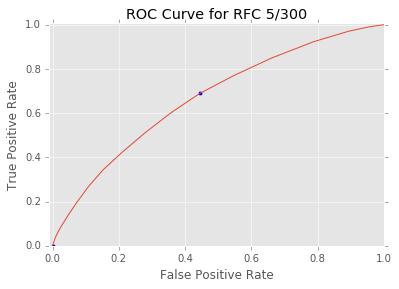

all   score: 0.845  baseline: 0.845   1-prec: 0.845   f1: 0.000  | test score 0.152  1-prec 0.848 f1 0.263  GP 851MM
2011  score: 0.887  baseline: 0.887   wscore: 0.887   f1: 0.000  | test score 0.896  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.867   f1: 0.000  | test score 0.863  1-prec 0.863
2013  score: 0.818  baseline: 0.818   wscore: 0.818   f1: 0.000  | test score 0.825  1-prec 0.825


In [64]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, n_estimators=300), model_name='RFC 5/300')

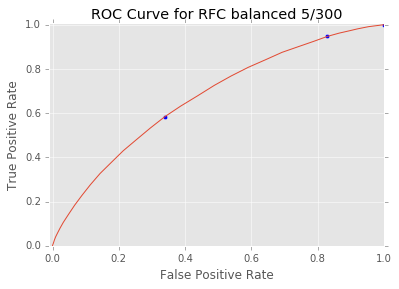

all   score: 0.660  baseline: 0.845   1-prec: 0.902   f1: 0.354  | test score 0.351  1-prec 0.899 f1 0.163  GP 302MM
2011  score: 0.759  baseline: 0.887   wscore: 0.905   f1: 0.239  | test score 0.765  1-prec 0.915
2012  score: 0.656  baseline: 0.867   wscore: 0.907   f1: 0.298  | test score 0.638  1-prec 0.894
2013  score: 0.662  baseline: 0.818   wscore: 0.883   f1: 0.390  | test score 0.657  1-prec 0.883


In [65]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, class_weight = 'balanced', n_estimators=300),
                   model_name='RFC balanced 5/300')

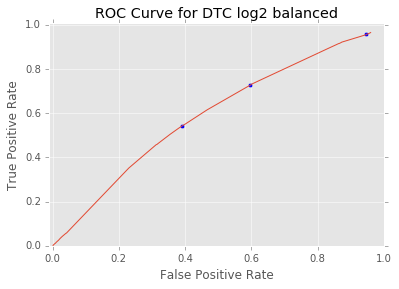

all   score: 0.622  baseline: 0.845   1-prec: 0.882   f1: 0.303  | test score 0.402  1-prec 0.882 f1 0.188  GP 323MM
2011  score: 0.641  baseline: 0.887   wscore: 0.897   f1: 0.202  | test score 0.607  1-prec 0.907
2012  score: 0.543  baseline: 0.867   wscore: 0.899   f1: 0.262  | test score 0.620  1-prec 0.887
2013  score: 0.606  baseline: 0.818   wscore: 0.855   f1: 0.326  | test score 0.681  1-prec 0.863


In [66]:
eval_model_by_year(lambda: DTC(max_depth = 10, max_features = 'log2', class_weight = 'balanced', criterion = 'gini'),
                  model_name='DTC log2 balanced')

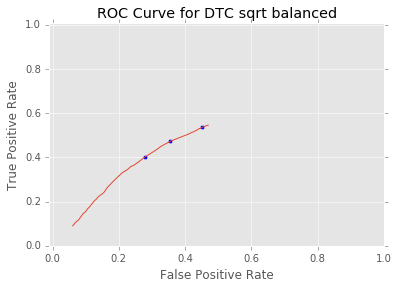

all   score: 0.669  baseline: 0.845   1-prec: 0.867   f1: 0.270  | test score 0.326  1-prec 0.871 f1 0.213  GP 458MM
2011  score: 0.728  baseline: 0.887   wscore: 0.889   f1: 0.164  | test score 0.636  1-prec 0.905
2012  score: 0.662  baseline: 0.867   wscore: 0.880   f1: 0.224  | test score 0.675  1-prec 0.880
2013  score: 0.656  baseline: 0.818   wscore: 0.844   f1: 0.301  | test score 0.659  1-prec 0.846


In [67]:
eval_model_by_year(lambda: DTC(max_depth = 20, max_features = 'sqrt', class_weight = 'balanced', criterion = 'entropy'),
                  model_name='DTC sqrt balanced')

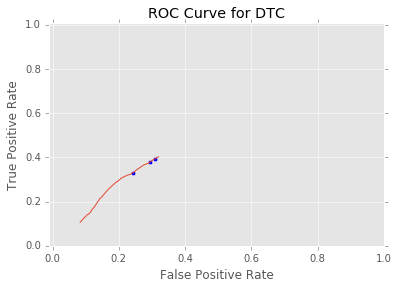

all   score: 0.692  baseline: 0.845   1-prec: 0.860   f1: 0.245  | test score 0.309  1-prec 0.863 f1 0.227  GP 464MM
2011  score: 0.771  baseline: 0.887   wscore: 0.888   f1: 0.135  | test score 0.788  1-prec 0.902
2012  score: 0.734  baseline: 0.867   wscore: 0.878   f1: 0.213  | test score 0.713  1-prec 0.875
2013  score: 0.677  baseline: 0.818   wscore: 0.838   f1: 0.279  | test score 0.680  1-prec 0.842


In [68]:
eval_model_by_year(lambda: DTC(max_depth = 20, max_features = None, class_weight = 'balanced', criterion = 'entropy'),
                  model_name='DTC')

In [69]:
# This takes a very long time for practically no uplift
#eval_model_all_years(lambda: SVC(class_weight='balanced', probability=True))

In [70]:
# This takes a very long time for practically no uplift
#eval_model_all_years(lambda: SVC(class_weight='balanced', probability=True), prob_threshold=0.85)

#### Other Models without PCA

In [71]:
# TODO: Try again, this time fitting a regression against the payments received

In [72]:
# Curious -- what are the 95 CI for the baselines?
for yr in set(years.values):
    yr_n = (years == yr).sum()
    yr_def = (y[years == yr]).sum()
    yr_p = (y[years == yr]).mean()
    yr_se = (yr_p * (1.0-yr_p) / yr_n)
    print "y=%4d   n=%4d   d=%4d   p: %.3f | %.3f | %.3f" % (yr, yr_n, yr_def, yr_p - 1.96*yr_se, yr_p, yr_p + 1.96*yr_se)

y=2011   n=2521   d= 286   p: 0.113 | 0.113 | 0.114
y=2012   n=7475   d= 994   p: 0.133 | 0.133 | 0.133
y=2013   n=9723   d=1767   p: 0.182 | 0.182 | 0.182


In [73]:
# Default rate for small business is higher, right?
print y.mean()
print y[x_expanded.loan_purpose__small_business == 1].mean()

0.154521020336
0.230563002681


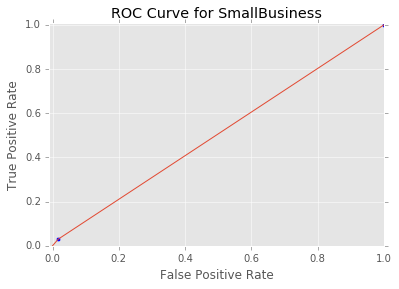

all   score: 0.835  baseline: 0.845   1-prec: 0.847   f1: 0.050  | test score 0.162  1-prec 0.850 f1 0.260  GP 819MM
2011  score: 0.714  baseline: 0.887   wscore: 0.856   f1: 0.070  | test score 0.874  1-prec 0.899
2012  score: 0.852  baseline: 0.867   wscore: 0.868   f1: 0.058  | test score 0.849  1-prec 0.865
2013  score: 0.816  baseline: 0.818   wscore: 0.820   f1: 0.042  | test score 0.821  1-prec 0.826


In [74]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), ['loan_purpose__small_business'], model_name='SmallBusiness')

In [75]:
# LogReg is doing well.. what are the largest coefficients?
lr = Log_Reg(class_weight='balanced').fit(x_expanded[years.isin([2011,2012,2013])], y[years.isin([2011,2012,2013])])
lr_coeff = pd.DataFrame(lr.coef_.T, index=x_expanded.columns)
lr_coeff.columns = ['coeff']
lr_coeff['abs'] = lr_coeff.coeff.abs()

In [76]:
lr_coeff.sort_values('abs', ascending=False).coeff

employ_title__walmart                        -1.725905
employ_title__manager                        -1.484858
employ_title__U.S._Army                      -1.458624
employ_title__The_Home_Depot                 -1.417935
employ_title__United_Parcel_Service          -1.297994
employ_title__USPS                            1.035226
employ_title__United_States_Postal_Service   -0.997333
employ_title__Director                       -0.940353
employ_title__Department_of_Defense          -0.918405
employ_title__Home_Depot                      0.905936
employ_title__JP_Morgan_Chase                -0.900937
employ_title__US_Army                        -0.900780
employ_title__State_of_California            -0.888989
employ_title__United_States_Air_Force        -0.854507
employ_title__driver                          0.812979
address_state__IA                             0.803846
loan_purpose__renewable_energy                0.729803
employ_title__Driver                         -0.701368
loan_amoun

In [77]:
lr_probs = lr.predict_proba(x_expanded)[:,0]

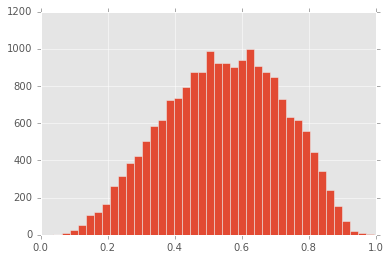

In [78]:
plt.hist(lr_probs ,bins=40)
plt.show()

In [79]:
1 - y.groupby([int(p*20)/20.0 for p in lr_probs]).mean()

0.00    1.000000
0.05    0.240000
0.10    0.542636
0.15    0.576512
0.20    0.638554
0.25    0.646341
0.30    0.709904
0.35    0.771469
0.40    0.794438
0.45    0.837359
0.50    0.858617
0.55    0.877285
0.60    0.897436
0.65    0.919066
0.70    0.939353
0.75    0.952229
0.80    0.971257
0.85    0.970803
0.90    0.978947
0.95    1.000000
Name: loan_status, dtype: float64

In [80]:
# probs = eval_model_with_threshold(lambda: Log_Reg())

In [81]:
# probs = eval_model_with_threshold(lambda: Log_Reg(class_weight='balanced'))

In [82]:
# VERY SLOW
#probs = eval_model_with_threshold(lambda: SVC(
#        random_state=1729,
#        probability=True))

#### Models with PCA

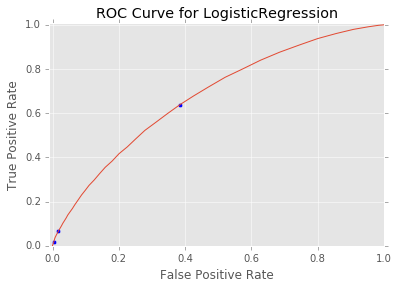

all   score: 0.845  baseline: 0.845   1-prec: 0.848   f1: 0.039  | test score 0.152  1-prec 0.850 f1 0.260  GP 842MM
2011  score: 0.886  baseline: 0.887   wscore: 0.888   f1: 0.035  | test score 0.895  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.868   f1: 0.010  | test score 0.862  1-prec 0.864
2013  score: 0.816  baseline: 0.818   wscore: 0.823   f1: 0.085  | test score 0.823  1-prec 0.830


In [83]:
eval_model_by_year(lambda: Log_Reg(), x = x_expanded_pca, x_test = x_test_expanded_pca)

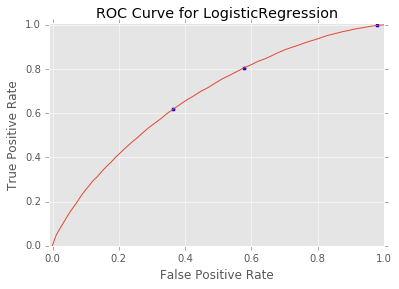

all   score: 0.641  baseline: 0.845   1-prec: 0.906   f1: 0.354  | test score 0.367  1-prec 0.903 f1 0.155  GP 271MM
2011  score: 0.631  baseline: 0.887   wscore: 0.916   f1: 0.249  | test score 0.630  1-prec 0.929
2012  score: 0.629  baseline: 0.867   wscore: 0.914   f1: 0.305  | test score 0.608  1-prec 0.901
2013  score: 0.645  baseline: 0.818   wscore: 0.888   f1: 0.393  | test score 0.636  1-prec 0.889


In [84]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), x = x_expanded_pca, x_test = x_test_expanded_pca)

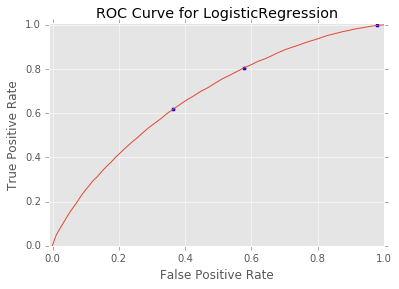

all   score: 0.641  baseline: 0.845   1-prec: 0.925   f1: 0.354  | test score 0.519  1-prec 0.924 f1 0.110  GP -35MM
2011  score: 0.631  baseline: 0.887   wscore: 0.921   f1: 0.249  | test score 0.630  1-prec 0.941
2012  score: 0.629  baseline: 0.867   wscore: 0.931   f1: 0.305  | test score 0.608  1-prec 0.921
2013  score: 0.645  baseline: 0.818   wscore: 0.910   f1: 0.393  | test score 0.636  1-prec 0.912


In [85]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), prob_threshold=.6, 
                   x = x_expanded_pca, x_test = x_test_expanded_pca)

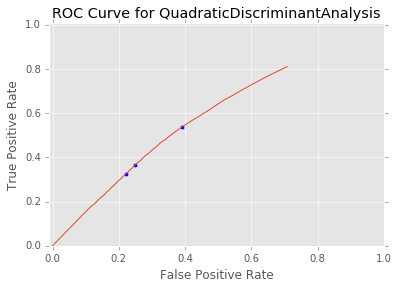

all   score: 0.705  baseline: 0.845   1-prec: 0.867   f1: 0.270  | test score 0.290  1-prec 0.866 f1 0.223  GP 526MM
2011  score: 0.687  baseline: 0.887   wscore: 0.896   f1: 0.194  | test score 0.726  1-prec 0.904
2012  score: 0.702  baseline: 0.867   wscore: 0.881   f1: 0.225  | test score 0.699  1-prec 0.876
2013  score: 0.707  baseline: 0.818   wscore: 0.841   f1: 0.288  | test score 0.689  1-prec 0.844


In [86]:
eval_model_by_year(lambda: QDA(), x = x_expanded_pca, x_test = x_test_expanded_pca)

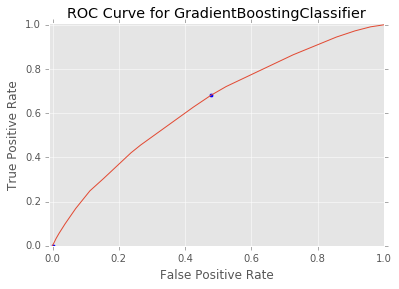

all   score: 0.845  baseline: 0.845   1-prec: 0.845   f1: 0.000  | test score 0.152  1-prec 0.848 f1 0.263  GP 851MM
2011  score: 0.886  baseline: 0.887   wscore: 0.887   f1: 0.000  | test score 0.896  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.867   f1: 0.000  | test score 0.863  1-prec 0.863
2013  score: 0.818  baseline: 0.818   wscore: 0.818   f1: 0.000  | test score 0.825  1-prec 0.825


In [87]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1),
                  x = x_expanded_pca, x_test = x_test_expanded_pca)

## NLP Modeling

#### Top Terms in Each Class

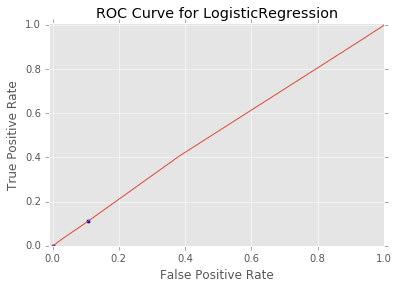

all   score: 0.860  baseline: 0.860   1-prec: 0.860   f1: 0.000  | test score 0.142  1-prec 0.858 f1 0.248  GP 211MM
2011  score: 0.899  baseline: 0.899   wscore: 0.899   f1: 0.000  | test score 0.899  1-prec 0.899
2012  score: 0.865  baseline: 0.865   wscore: 0.865   f1: 0.000  | test score 0.866  1-prec 0.866
2013  score: 0.834  baseline: 0.834   wscore: 0.834   f1: 0.000  | test score 0.827  1-prec 0.827


In [88]:
eval_model_by_year(lambda: Log_Reg(), x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

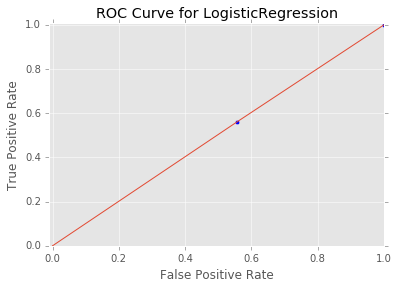

all   score: 0.465  baseline: 0.860   1-prec: 0.862   f1: 0.219  | test score 0.540  1-prec 0.859 f1 0.213  GP 2MM
2011  score: 0.739  baseline: 0.899   wscore: 0.896   f1: 0.110  | test score 0.849  1-prec 0.900
2012  score: 0.790  baseline: 0.865   wscore: 0.866   f1: 0.119  | test score 0.713  1-prec 0.864
2013  score: 0.244  baseline: 0.834   wscore: 0.824   f1: 0.274  | test score 0.464  1-prec 0.823


In [89]:
eval_model_by_year(lambda: Log_Reg(C = 10 ** -6, class_weight = 'balanced'), 
                   x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

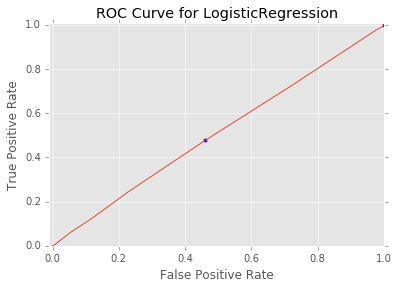

all   score: 0.558  baseline: 0.860   1-prec: nan   f1: 0.212  | test score 0.858  1-prec 0.818 f1 0.002  GP -159MM
2011  score: 0.555  baseline: 0.899   wscore: 0.905   f1: 0.158  | test score 0.550  1-prec 0.876
2012  score: 0.478  baseline: 0.865   wscore: 0.911   f1: 0.218  | test score 0.458  1-prec 0.837
2013  score: 0.534  baseline: 0.834   wscore: 0.847   f1: 0.233  | test score 0.471  1-prec 0.853


In [90]:
eval_model_by_year(lambda: Log_Reg(class_weight = 'balanced'), prob_threshold = 0.6,
                   x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

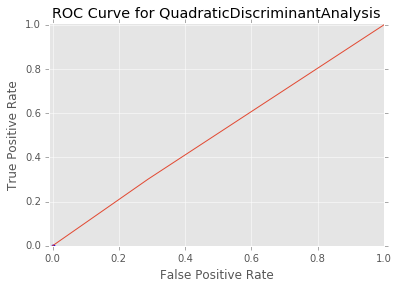

all   score: 0.860  baseline: 0.860   1-prec: 0.860   f1: 0.000  | test score 0.142  1-prec 0.858 f1 0.248  GP 211MM
2011  score: 0.899  baseline: 0.899   wscore: 0.899   f1: 0.000  | test score 0.899  1-prec 0.899
2012  score: 0.865  baseline: 0.865   wscore: 0.865   f1: 0.000  | test score 0.866  1-prec 0.866
2013  score: 0.834  baseline: 0.834   wscore: 0.834   f1: 0.000  | test score 0.827  1-prec 0.827


In [91]:
eval_model_by_year(lambda: QDA(reg_param = 1), x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

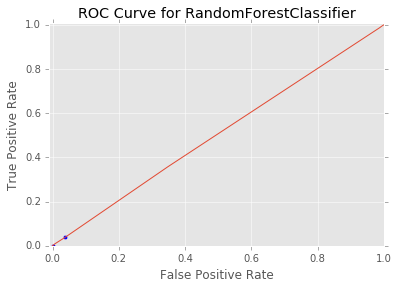

all   score: 0.860  baseline: 0.860   1-prec: 0.860   f1: 0.000  | test score 0.142  1-prec 0.858 f1 0.248  GP 211MM
2011  score: 0.899  baseline: 0.899   wscore: 0.899   f1: 0.000  | test score 0.899  1-prec 0.899
2012  score: 0.865  baseline: 0.865   wscore: 0.865   f1: 0.000  | test score 0.866  1-prec 0.866
2013  score: 0.834  baseline: 0.834   wscore: 0.834   f1: 0.000  | test score 0.827  1-prec 0.827


In [92]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, n_estimators=300),
                    x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

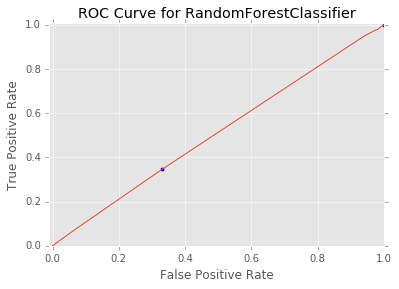

all   score: 0.627  baseline: 0.860   1-prec: 0.861   f1: 0.197  | test score 0.376  1-prec 0.861 f1 0.229  GP 85MM
2011  score: 0.713  baseline: 0.899   wscore: 0.897   f1: 0.130  | test score 0.729  1-prec 0.895
2012  score: 0.531  baseline: 0.865   wscore: 0.868   f1: 0.215  | test score 0.486  1-prec 0.861
2013  score: 0.636  baseline: 0.834   wscore: 0.833   f1: 0.206  | test score 0.551  1-prec 0.822


In [93]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, n_estimators=300, class_weight = 'balanced'),
                    x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

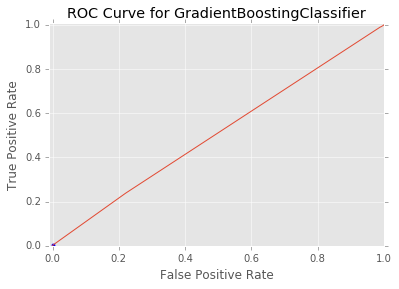

all   score: 0.860  baseline: 0.860   1-prec: 0.860   f1: 0.000  | test score 0.142  1-prec 0.858 f1 0.248  GP 211MM
2011  score: 0.899  baseline: 0.899   wscore: 0.899   f1: 0.000  | test score 0.899  1-prec 0.899
2012  score: 0.865  baseline: 0.865   wscore: 0.865   f1: 0.000  | test score 0.866  1-prec 0.866
2013  score: 0.834  baseline: 0.834   wscore: 0.834   f1: 0.000  | test score 0.827  1-prec 0.827


In [94]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1),
                    x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

#### Full Document-Term Matrix (Reduced with PCA)

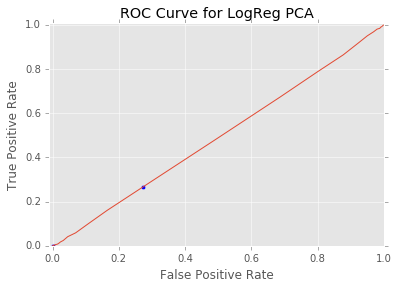

all   score: 0.860  baseline: 0.860   1-prec: 0.860   f1: 0.001  | test score 0.143  1-prec 0.858 f1 0.249  GP 216MM
2011  score: 0.894  baseline: 0.899   wscore: 0.899   f1: 0.009  | test score 0.890  1-prec 0.898
2012  score: 0.861  baseline: 0.865   wscore: 0.865   f1: 0.003  | test score 0.862  1-prec 0.866
2013  score: 0.832  baseline: 0.834   wscore: 0.834   f1: 0.000  | test score 0.825  1-prec 0.827


In [95]:
eval_model_by_year(lambda: Log_Reg(), x = desc_matrix_pca, x_test = desc_matrix_test_pca, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                   model_name='LogReg PCA')

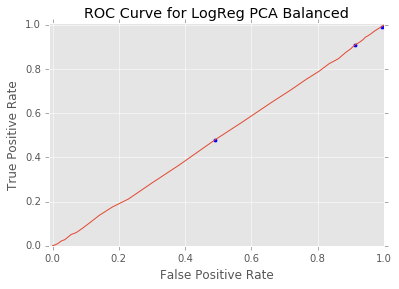

all   score: 0.512  baseline: 0.860   1-prec: 0.861   f1: 0.218  | test score 0.495  1-prec 0.856 f1 0.226  GP 30MM
2011  score: 0.613  baseline: 0.899   wscore: 0.898   f1: 0.155  | test score 0.604  1-prec 0.889
2012  score: 0.526  baseline: 0.865   wscore: 0.867   f1: 0.213  | test score 0.533  1-prec 0.863
2013  score: 0.526  baseline: 0.834   wscore: 0.832   f1: 0.238  | test score 0.517  1-prec 0.822


In [96]:
eval_model_by_year(lambda: Log_Reg(class_weight = 'balanced'), x = desc_matrix_pca, x_test = desc_matrix_test_pca, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                   model_name='LogReg PCA Balanced')

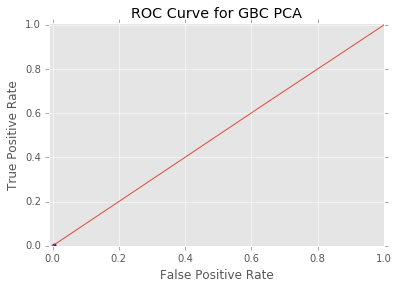

all   score: 0.860  baseline: 0.860   1-prec: 0.860   f1: 0.000  | test score 0.142  1-prec 0.858 f1 0.248  GP 217MM
2011  score: 0.898  baseline: 0.899   wscore: 0.899   f1: 0.000  | test score 0.899  1-prec 0.899
2012  score: 0.865  baseline: 0.865   wscore: 0.865   f1: 0.000  | test score 0.866  1-prec 0.866
2013  score: 0.834  baseline: 0.834   wscore: 0.834   f1: 0.000  | test score 0.827  1-prec 0.827


In [97]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1),
                   x = desc_matrix_pca, x_test = desc_matrix_test_pca,
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                   model_name='GBC PCA')

## Stacking

In [98]:
# function to create model stack
def create_model_stack(x_train, y_train):
    model_stack = []

    model_stack.append(Log_Reg(C = 10 ** -5, class_weight = 'balanced').fit(x_train, y_train))
    model_stack.append(LDA(shrinkage = 1, solver = 'lsqr').fit(x_train, y_train))
    model_stack.append(QDA(reg_param = 1).fit(x_train, y_train))
    model_stack.append(RFC(n_estimators = 300, max_depth = 5, class_weight = 'balanced').fit(x_train, y_train))
    model_stack.append(GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1).fit(x_train, y_train))
    model_stack.append(DTC(max_depth = 10, max_features = 'log2', class_weight = 'balanced', 
                           criterion = 'gini').fit(x_train, y_train))
    model_stack.append(DTC(max_depth = 20, max_features = 'sqrt', class_weight = 'balanced', 
                           criterion = 'entropy').fit(x_train, y_train))
    model_stack.append(DTC(max_depth = 20, max_features = None, 
                           criterion = 'entropy').fit(x_train, y_train))
    #model_stack.append(SVC(class_weight = 'balanced').fit(x_train, y_train))
    
    return model_stack

In [99]:
# function to fit and score a stacking ensemble
# TO DO: CV
def fit_score_stacking(model_stack, x_train, y_train, x_test, y_test, combiner):
    n_train = x_train.shape[0]
    n_test = x_test.shape[0]
    num_models = len(model_stack)

    # create variables to hold predictions
    y_train_stack = np.zeros((n_train, num_models))
    y_test_stack = np.zeros((n_test, num_models))

    # predict with each model on training and testing data
    for index in range(num_models):
        model = model_stack[index]
        y_train_stack[:, index] = model.predict(x_train)
        y_test_stack[:, index] = model.predict(x_test)

    # fit and predict with ensemble
    combiner.fit(y_train_stack, y_train)
    test_y_hat = combiner.predict(y_test_stack)
    
    # score with ensemble
    score = combiner.score(y_train_stack, y_train)
    test_score = combiner.score(y_test_stack, y_test)
    cm = confusion_matrix(y_test, test_y_hat)
    test_f1 = f1_score(y_test, test_y_hat, pos_label = 1)
    test_precision = 1 - y_test[test_y_hat].mean()
    
    # format confusion matrix
    cm_df = pd.DataFrame(cm, columns = ["Predicted_bad", "Predicted_good"])
    row_labels = pd.DataFrame(["Actual_bad", "Actual_good"])
    cm_df = pd.concat((row_labels, cm_df), axis = 1)
    
    profit_mm = calc_expected_profit(profit_data_test, test_y_hat)

    return score, test_score, cm_df, test_f1, test_precision, profit_mm

In [100]:
# fit and score a stacked model for given predictors and response
def try_one_stacked_model(model_stack, x_train, y_train, x_test, y_test, combiner):

    score, test_score, cm_df, test_f1, test_precision, profit_mm = \
        fit_score_stacking(model_stack, x_train, y_train, x_test, y_test, combiner)

    print "%d  score: %.3f  baseline: %.3f   wscore: ----   f1: ----  | test score %.3f  1-prec %.3f f1 %.3f  GP %dMM" \
         % (0, score, 1 - y_train.mean(), test_score, test_precision, test_f1, profit_mm)

#### Regular Data

In [101]:
model_stack = create_model_stack(x_expanded, y)

In [102]:
combiner = Log_Reg(C = 10 ** -5, class_weight = 'balanced', penalty = 'l2', solver = 'liblinear')
try_one_stacked_model(model_stack, x_expanded, y, x_test_expanded, y_test, combiner)

0  score: 0.490  baseline: 0.845   wscore: ----   f1: ----  | test score 0.419  1-prec 0.815 f1 0.302  GP 370MM


In [103]:
combiner = RFC(class_weight = 'balanced')
try_one_stacked_model(model_stack, x_expanded, y, x_test_expanded, y_test, combiner)

0  score: 0.898  baseline: 0.845   wscore: ----   f1: ----  | test score 0.719  1-prec 0.775 f1 0.273  GP -297MM


## Visualizations

In [104]:
pd.DataFrame(model_performance).T

,baseline,f1,prec,score,test_f1,test_prec,test_profit,test_score
Always 1,0.845479,0.000000,0.845479,0.845479,0.263391,0.848331,851.209909,0.151669
DTC,0.845479,0.244964,0.859962,0.692125,0.226766,0.863459,464.282132,0.308530
DTC log2 balanced,0.845479,0.303023,0.882010,0.622293,0.187999,0.881633,323.044847,0.401766
DTC sqrt balanced,0.845479,0.269902,0.867174,0.668747,0.212625,0.870776,458.393061,0.326446
GBC,0.845479,0.000000,0.845479,0.845479,0.263391,0.848331,851.209909,0.151669
GBC PCA,0.860461,0.000000,0.860461,0.860461,0.248382,0.858198,217.168405,0.141802
GradientBoostingClassifier,0.860461,0.000000,0.860461,0.860461,0.248382,0.858198,211.123874,0.141802
LogReg,0.845479,0.042630,0.847730,0.844465,0.259356,0.850509,840.782418,0.152428
LogReg PCA,0.860461,0.000793,0.860398,0.859720,0.248602,0.858055,216.835795,0.142809
LogReg PCA Balanced,0.860461,0.217756,0.861136,0.512469,0.225886,0.855657,30.692679,0.495399


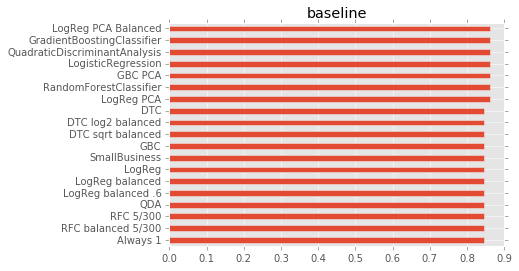

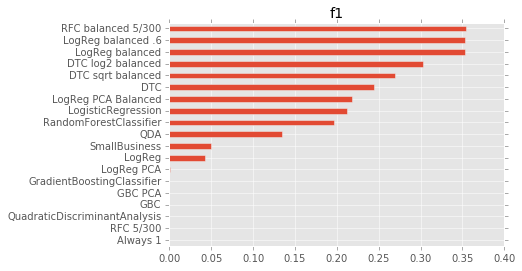

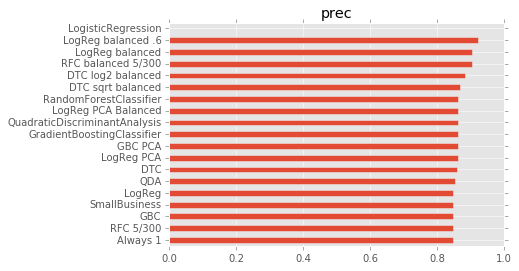

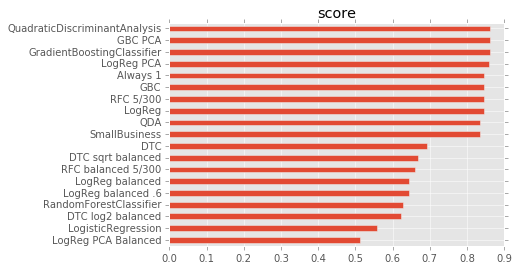

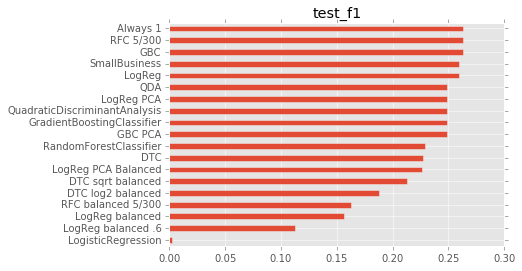

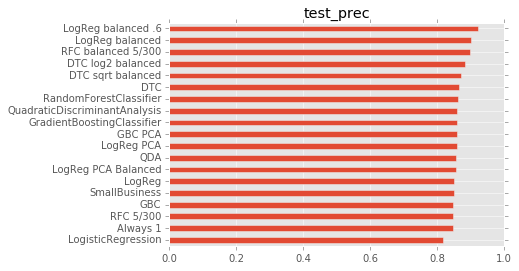

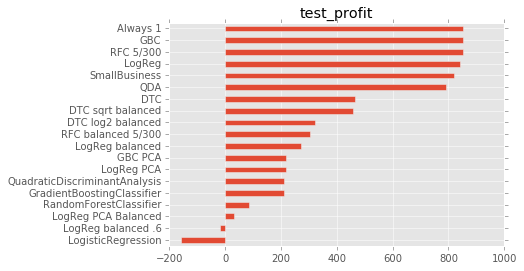

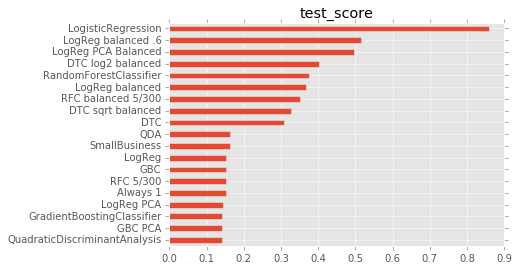

In [105]:
model_performance_df = pd.DataFrame(model_performance).T
for col in model_performance_df.columns:
    model_performance_df[col].sort_values().plot(kind='barh')
    plt.title(col)
    plt.show()